In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt 
import torch.nn as nn 
from torch.optim import SGD 

In [8]:
%config InlineBackend.figure_format = 'svg'

# Improving our previous rudimentary network 

We defined a network based on a function that multiplies the input by two matrices $A_1$ and $A_2$. 

$$ \text{Old Model: } \textcolor{red}{\boxed{f(x) = A_2 \cdot A_1 \cdot x}} $$ 

However, despite choosing $8 \times 2$ and $8 \times 1$ matrices, their resulting product is a $2 \times 1$ matrix, which has a very small number of total parameters. 

So in reality, we ended up having 

$$ \text{Old Model: } f(x) = B \cdot x $$ 

where $B$ is a $2 \times 1$ matrix.

We can improve upon this by defining the new model as such:

$$ \text{New Model:  } \textcolor{green}{\boxed{f(x) = A_2 \cdot R (A_1 \cdot x)}} $$

where $R$ is an element-wise operator defined by 

$$ R(x) = \begin{cases} x & \text{if } x > 0 \\ 0 & \text{if } x \leq 0 \end{cases} $$

The **Crux** of Machine Learning lies in so-called **Activation Functions**, which add subtle non-linearities to a sequence of matrix transformations. 

In the above example, $R$ is an identity function for positive values, and a function that clamps negative values to zero.

This makes our activation function **close** to being a linear operator, but not quite.

In [3]:
x = torch.tensor([[4,6,2,-1,6,2,5], [1,6,2,-6,5,-3,5]])
x, x.shape

(tensor([[ 4,  6,  2, -1,  6,  2,  5],
         [ 1,  6,  2, -6,  5, -3,  5]]),
 torch.Size([2, 7]))

The $R$ function is called a **Rectified Linear Unit** or **ReLU** for short, and PyTorch has a built-in implementation of it, very conveniently.

In [5]:
R = nn.ReLU()
R(x), R(x).shape

(tensor([[4, 6, 2, 0, 6, 2, 5],
         [1, 6, 2, 0, 5, 0, 5]]),
 torch.Size([2, 7]))

Another example

In [6]:
x = torch.linspace(-3, 3, 1000)
y = R(x)

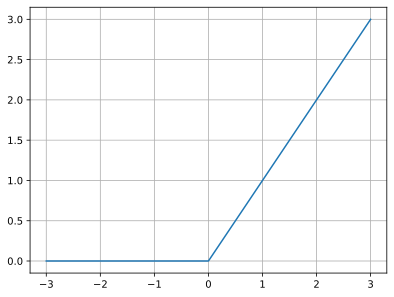

In [9]:
plt.plot(x.numpy(), y.numpy())
plt.grid()
plt.show()

How does this slightly more complex model compare to the previous one?

Let's create the new Network and see how it performs.

In [10]:
class my_ReLU_network(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.Matrix1 = nn.Linear(2, 8, bias=False)
        self.Matrix2 = nn.Linear(8, 1, bias=False)
        self.R = nn.ReLU()
    def forward(self, x): 
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()

Let's now train the new model, but first let's write a function to do so, as it will come in handy later.

In [11]:
def train_model(x, y, f, n_epochs, learning_rate):
    opt = SGD(f.parameters(), lr=learning_rate)
    L = nn.MSELoss()

    losses = []
    for _ in range(n_epochs):
        opt.zero_grad() # flush the previous epoch's gradient, or it would cumulate
        loss_value = L(f(x), y) # compute loss 
        loss_value.backward() # compute the gradient
        opt.step() # perform the iteration using the gradient above 
        losses.append(loss_value.item())
    return f, losses

Let's use the same values we used for the previous model.

In [14]:
x = torch.tensor([[6, 2], [5, 2], [1, 3], [7, 6]]).float()
y = torch.tensor([1, 5, 2, 5]).float()
fun = my_ReLU_network()

Let's also train for the same number of epochs and use the same learning rate, just to make sure we are comparing apples to apples.

In [15]:
f, losses = train_model(x, y, fun, n_epochs=50, learning_rate=0.001)
yhat = f(x)

Let's see our predictions!

In [16]:
y, yhat

(tensor([1., 5., 2., 5.]),
 tensor([2.6278, 2.3746, 1.9506, 5.0980], grad_fn=<SqueezeBackward0>))

This is still not great, but the predictions are a bit more accurate than before. However, this is not the end of the story. 

The real advantage of using this **Activation Function** is that we can use much larger matrices in the first place, whereas the previous model would collapse our parameters to a very small matrix regardless of the size of the input.

Let's put this into practice by redefining the class to use $A_2$ as $1 \times 80$ and $A_1$ as $80 \times 2$.

In [25]:
class my_ReLU_network_size(nn.Module): 
    def __init__(self, dim) -> None:
        super().__init__()
        self.Matrix1 = nn.Linear(2, dim, bias=False)
        self.Matrix2 = nn.Linear(dim, 1, bias=False)
        self.R = nn.ReLU()
    def forward(self, x): 
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()

In [28]:
x = torch.tensor([[6, 2], [5, 2], [1, 3], [7, 6]]).float()
y = torch.tensor([1, 5, 2, 5]).float()
fun = my_ReLU_network_size(80)

In [30]:
f, losses = train_model(x, y, fun, 50, learning_rate=0.001)
yhat = f(x)

In [31]:
y, yhat

(tensor([1., 5., 2., 5.]),
 tensor([2.8100, 2.5250, 1.9061, 5.2396], grad_fn=<SqueezeBackward0>))

Let's also train for a very large number of epochs and let's play with the learning rate.

In [47]:
x = torch.tensor([[6, 2], [5, 2], [1, 3], [7, 6]]).float()
y = torch.tensor([1, 5, 2, 5]).float()
fun = my_ReLU_network_size(80)

f, losses = train_model(x, y, fun, 5000, learning_rate=0.001)
yhat = f(x)

y, yhat

# Quick note: this actually converges to the ideal result with a size 80 for the matrices, 5000 epochs and a larger learning rate of 0.01,
# it seems to get not too close sometimes and occasionally it converges

(tensor([1., 5., 2., 5.]),
 tensor([1.6963, 3.9989, 1.9181, 5.1362], grad_fn=<SqueezeBackward0>))

We can still improve upon our model by introducing other parameters: 


$$ \textcolor{red}{\boxed{\text{First Model: } f(x) = A_2 \cdot A_1 \cdot x}} $$

$$ \textcolor{yellow}{\boxed{\text{Previous Model: } f(x) = A_2 \cdot R (A_1 \cdot x)}} $$

$$ \textcolor{green}{\boxed{\text{New Model: } f(x) = A_2 \cdot R (A_1 \cdot x + b_1) + b_2}} $$

where $b_1$ and $b_2$ are vectors added to each of the linear transformations, commonly known as **bias** parameters.

In [48]:
class ReLU_biased_network(nn.Module): 
    def __init__(self, dim) -> None:
        super().__init__()
        self.Matrix1 = nn.Linear(2, dim, bias=True)
        self.Matrix2 = nn.Linear(dim, 1, bias=True)
        self.R = nn.ReLU()
    def forward(self, x): 
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()
    
# bias=True could be omitted as it's the default value

Let's retrain with our biased model.

In [51]:
x = torch.tensor([[6, 2], [5, 2], [1, 3], [7, 6]]).float()
y = torch.tensor([1, 5, 2, 5]).float()
fun = ReLU_biased_network(80)

f, losses = train_model(x, y, fun, 5000, learning_rate=0.001)
yhat = f(x)

y, yhat

(tensor([1., 5., 2., 5.]),
 tensor([1.3814, 4.5234, 2.0195, 5.0155], grad_fn=<SqueezeBackward0>))

Closer! But still not there.

What if we added another matrix in the middle? Let's make one final adjustment to our model by introducing an $80 \times 80$ matrix in the middle and the corresponding bias vector.

$$ \textcolor{red}{\boxed{\text{First Model: } f(x) = A_2 \cdot A_1 \cdot x}} $$

$$ \textcolor{orange}{\boxed{\text{Previous Model 1: } f(x) = A_2 \cdot R (A_1 \cdot x)}} $$

$$ \textcolor{yellow}{\boxed{\text{Previous Model 2: } f(x) = A_2 \cdot R (A_1 \cdot x + b_1) + b_2}} $$

$$ \textcolor{green}{\boxed{\text{New Model: } f(x) = A_3 \cdot R (A_2 \cdot R (A_1 \cdot x + b_1) + b_2) + b_3}} $$

In [52]:
class M3_ReLU_biased_network(nn.Module):
    def __init__(self, dim) -> None:
        super().__init__()
        self.Matrix1 = nn.Linear(2, dim, bias=True)
        self.Matrix2 = nn.Linear(dim, dim, bias=True)
        self.Matrix3 = nn.Linear(dim, 1, bias=True)
        self.R = nn.ReLU()
    def forward(self, x): 
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

Let's train it!

In [73]:
x = torch.tensor([[6, 2], [5, 2], [1, 3], [7, 6]]).float()
y = torch.tensor([1, 5, 2, 5]).float()
fun = M3_ReLU_biased_network(15)

f, losses = train_model(x, y, fun, 5000, learning_rate=0.01)
yhat = f(x)

y, yhat

# Note that this actually converges all the time with a size of 80 (as low as 15!), 5000 epochs and a larger learning rate of 0.01

(tensor([1., 5., 2., 5.]),
 tensor([1.0000, 5.0000, 2.0000, 5.0000], grad_fn=<SqueezeBackward0>))

We finally got some pretty close predictions!

# The Sequential Neural Network

All of this leads us to the **Sequential Neural Network**, which is a very common type of network that is used in practice. 

It's simply a generalization of the previous model, where we can add as many layers as we want, and each layer can have as many parameters as we want. 

A general Sequential Neural Network is defined as such: 

$$ \textcolor{green}{\boxed{f(x) = \displaystyle {\Huge{\kappa}}_{i=1}^n R_i (A_i \cdot x + b_i)}}$$

where ${\Huge{\kappa}}_{i=1}^n = f_n \circ f_{n-1} \circ \cdots \circ f_1(x)$ is an operator that chains functions, $A_i$ are matrices, $b_i$ are **bias** vectors, and $R_i$ are **activation functions**, typically **ReLU** for all layers except the last one, where it's usually just an **identity** function.

+ **Note**: In clever architectures, like convolutional neural networks, the matrices $A_i$ are not just regular matrices, but rather sparse matrices that are optimized for the specific task at hand.